In [1]:
%load_ext rpy2.ipython
from IPython.display import FileLink

In [2]:
%%R
library(dplyr); library(tidyr)
library(ggplot2)
library(gridExtra)


Attaching package: ‘dplyr’

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Find out what's changed in ggplot2 with
news(Version == "1.0.0", package = "ggplot2")
Loading required package: grid


###These files are from the [l2fc sparsity notebook](./Sparsity_make_l2fc_table.ipynb) and [l2fc no sparsity notebook](./l2fc_table_nospar.ipynb)

In [3]:
%%R
l2fc.all = read.csv("data/l2fc_table_no_spar.csv")
l2fc.filtered = read.csv("/var/seq_data/priming_exp/data/l2fc_table.csv")

In [4]:
%%R
head(l2fc.all)

  Day Treatment       OTU log2FoldChange    lfcSE    Rank1          Rank2
1  14    13C000 OTU.14353             NA       NA Bacteria  Acidobacteria
2  14    13C000 OTU.11642     -0.9017218 1.536176 Bacteria           <NA>
3  14    13C000  OTU.9532             NA       NA Bacteria Proteobacteria
4  14    13C000 OTU.12098             NA       NA Bacteria Proteobacteria
5  14    13C000 OTU.12051             NA       NA Bacteria Proteobacteria
6  14    13C000 OTU.12843             NA       NA Bacteria Proteobacteria
                Rank3        Rank4          Rank5                Rank6
1               DA023         <NA>           <NA>                 <NA>
2                <NA>         <NA>           <NA>                 <NA>
3 Deltaproteobacteria Myxococcales       MSB-4B10                 <NA>
4 Deltaproteobacteria Myxococcales       MSB-4B10                 <NA>
5 Deltaproteobacteria Myxococcales Nannocystineae        Haliangiaceae
6 Deltaproteobacteria Myxococcales       MSB-4B10 uncult

In [5]:
%%R
head(l2fc.filtered)

  sparsity_threshold Day Treatment       OTU log2FoldChange         p    Rank1
1               0.25  14    13C000  OTU.4204    -0.20553170 1.0000000 Bacteria
2               0.25  14    13C000   OTU.467    -0.33054855 1.0000000 Bacteria
3               0.25  14    13C000   OTU.905     0.01698885 0.9827594 Bacteria
4               0.25  14    13C000  OTU.7253     0.02799601 0.9772968 Bacteria
5               0.25  14    13C000    OTU.67    -0.60115954 1.0000000 Bacteria
6               0.25  14    13C000 OTU.10580     0.36193427 0.7248674 Bacteria
          Rank2 Rank3                Rank4 Rank5 Rank6 Rank7 Rank8 padj
1 Acidobacteria DA023                 <NA>  <NA>  <NA>  <NA>  <NA>    1
2 Acidobacteria DA023 uncultured_bacterium  <NA>  <NA>  <NA>  <NA>    1
3 Acidobacteria DA023 uncultured_bacterium  <NA>  <NA>  <NA>  <NA>    1
4 Acidobacteria DA023 uncultured_bacterium  <NA>  <NA>  <NA>  <NA>    1
5 Acidobacteria DA023 uncultured_bacterium  <NA>  <NA>  <NA>  <NA>    1
6 Acidobacteria

In [6]:
%%R
FDR = 0.10

d1 = l2fc.filtered %>%
    filter(Treatment %in% c("13C000", "13C100")) %>%
    group_by(OTU, Treatment, Rank2) %>%
    summarize(minP = min(padj)) %>%
    filter(minP <= FDR) %>%
    group_by(OTU) %>%
    summarize(rspnse = sum(minP <= FDR)) %>%
    mutate(rspnse.t = ifelse(rspnse == 2, "Yes", "No"))

rspndrs = unique(d1$OTU)

d2 = l2fc.all %>%
    filter(Treatment %in% c("13C000", "13C100")) %>%
    group_by(OTU, Rank2, Rank3, Treatment) %>%
    summarize(max.l2fc = max(log2FoldChange, na.rm = TRUE)) %>%
    group_by() %>%
    spread(Treatment, max.l2fc)

d = left_join(d1, d2)
d

Joining by: "OTU"
Source: local data frame [454 x 7]

         OTU rspnse rspnse.t          Rank2                          Rank3
1      OTU.1      1       No Actinobacteria                  Micrococcales
2     OTU.10      2      Yes Proteobacteria            Alphaproteobacteria
3   OTU.1009      2      Yes  Bacteroidetes               Sphingobacteriia
4    OTU.101      1       No Actinobacteria               Streptomycetales
5  OTU.10167      2      Yes  Acidobacteria Candidatus_Chloracidobacterium
6    OTU.102      2      Yes  Bacteroidetes               Sphingobacteriia
7  OTU.10228      1       No  Bacteroidetes                     Cytophagia
8   OTU.1029      1       No Planctomycetes                          OM190
9   OTU.1032      2      Yes  Bacteroidetes               Sphingobacteriia
10  OTU.1041      2      Yes Proteobacteria            Deltaproteobacteria
..       ...    ...      ...            ...                            ...
Variables not shown: 13C000 (dbl), 13C100 (dbl

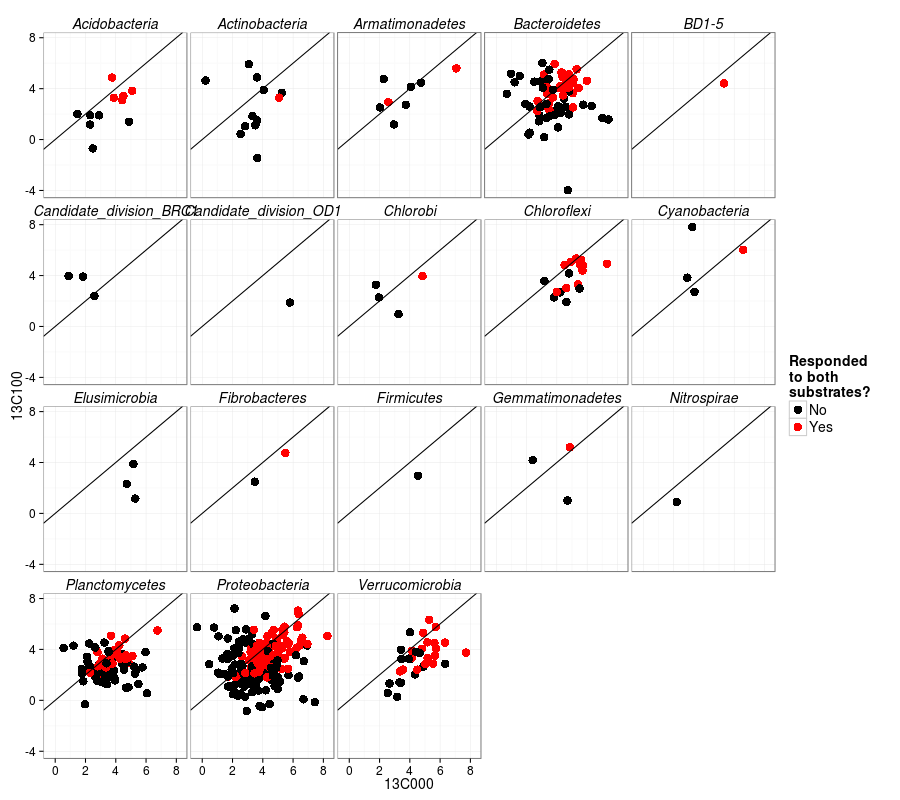

In [7]:
%%R -w 900 -h 800

p = ggplot(d, aes(x = `13C000`, y = `13C100`, color = rspnse.t))

p = p + scale_color_manual(values = c("black", "red"))

p = p + facet_wrap(~Rank2)

p = p + geom_point(size = 4)

p = p + geom_abline(intercept = 0)

p = p + theme_bw()

p = p + labs(color = "Responded\nto both\nsubstrates?")

p = p + theme(strip.background = element_blank(),
              strip.text = element_text(size = 14, face = "italic"),
              axis.text = element_text(size = 12),
              axis.title = element_text(size = 14),
              legend.title = element_text(size = 14),
              legend.text = element_text(size = 14))

p

In [8]:
%%R
FDR = 0.10

df.rspndrs = read.csv("/var/seq_data/priming_exp/data/l2fc_table.csv") %>%
    filter(Treatment %in% c("13C000", "13C100")) %>%
    group_by(OTU, Treatment) %>%
    summarize(minP = min(padj)) %>%
    filter(minP <= FDR) %>%
    group_by() %>%
    spread(Treatment, minP)

rspnse = function(x) {
    ifelse(sum(x <= FDR, na.rm = TRUE) == 2, "Both", ifelse(!is.na(x[1]), "Cellulose Only", "Root Exudate Continuous"))
}

df.rspndrs$rspnse = apply(df.rspndrs[,c("13C000", "13C100")], 1, rspnse)

df.rspndrs = df.rspndrs %>% select(OTU, rspnse)

df.rspndrs

Source: local data frame [454 x 2]

         OTU         rspnse
1      OTU.1 Cellulose Only
2     OTU.10           Both
3   OTU.1009           Both
4    OTU.101 Cellulose Only
5  OTU.10167           Both
6    OTU.102           Both
7  OTU.10228 Cellulose Only
8   OTU.1029 Cellulose Only
9   OTU.1032           Both
10  OTU.1041           Both
..       ...            ...


In [9]:
%%R
df.100 = l2fc.all %>%
        filter(Treatment %in% c("13C000", "13C100")) %>%
        left_join(df.rspndrs) %>%
        group_by(Rank2) %>%
        mutate(phylum.rspnse = ifelse(sum(!is.na(rspnse)) > 0, "rspndr", "none")) %>%
        filter(phylum.rspnse == "rspndr") %>%
        group_by(OTU, Rank2, Rank3, Treatment) %>%
        summarize(max.l2fc = max(log2FoldChange, na.rm = TRUE)) %>%
        group_by() %>%
        spread(Treatment, max.l2fc) %>%
        left_join(df.rspndrs)
print(df.100)

Joining by: "OTU"
Joining by: "OTU"
Source: local data frame [9,897 x 6]

         OTU          Rank2               Rank3      13C000      13C100
1      OTU.1 Actinobacteria       Micrococcales  2.53194715  0.42411193
2     OTU.10 Proteobacteria Alphaproteobacteria  5.26551206  4.28455713
3    OTU.100 Actinobacteria     Thermoleophilia -0.70128335 -1.08095557
4   OTU.1000 Actinobacteria Propionibacteriales  0.03255133  0.06468909
5  OTU.10000 Proteobacteria Deltaproteobacteria -0.64237617  1.87777612
6  OTU.10009 Proteobacteria  Betaproteobacteria          NA          NA
7   OTU.1001 Proteobacteria Deltaproteobacteria  2.04268588 -0.32550574
8  OTU.10015 Planctomycetes    Planctomycetacia  0.90396514          NA
9  OTU.10016 Proteobacteria Alphaproteobacteria          NA          NA
10 OTU.10017  Acidobacteria               DA023          NA          NA
..       ...            ...                 ...         ...         ...
Variables not shown: rspnse (chr)


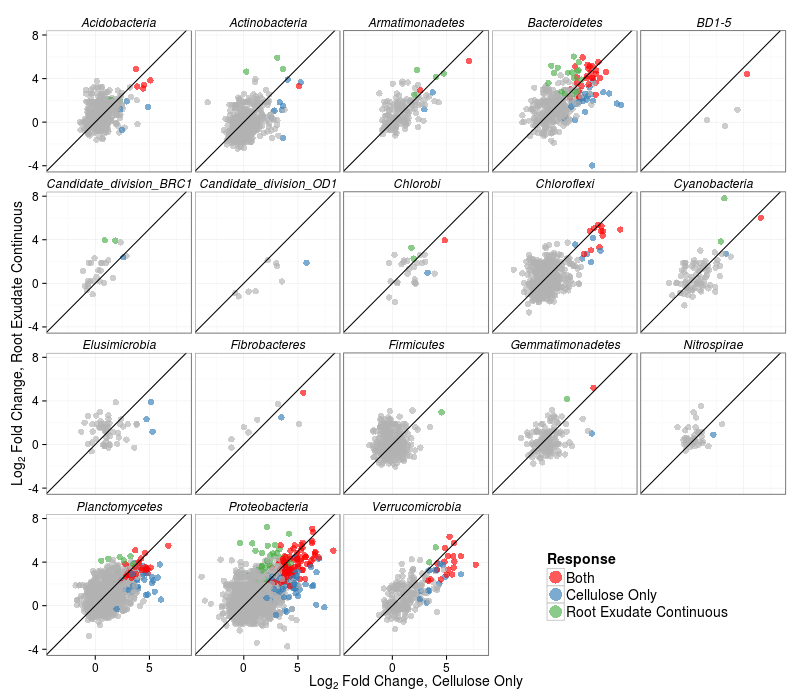

In [32]:
%%R -w 800 -h 700
FDR = 0.10

colours = c("red", "#377eb8", "#4daf4a")

p = ggplot(df.100, aes(x = `13C000`, y = `13C100`, color = rspnse))

#p = p + scale_color_manual(values = c("black", "red"))

p = p + facet_wrap(~Rank2)

p = p + geom_point(size = 3, alpha = 0.65)

p = p + geom_abline(intercept = 0)

p = p + scale_color_manual(values = colours, na.value = "grey70")

p = p + theme_bw()

p = p + labs(color = "Response")

p = p + labs(y = expression(paste("", Log[2]," Fold Change,"," Root Exudate Continuous",sep="")), 
             x = expression(paste("", Log[2]," Fold Change,"," Cellulose Only",sep="")))


p = p + theme(strip.background = element_blank(),
              strip.text = element_text(size = 12, face = "italic"),
              axis.text = element_text(size = 12),
              axis.title = element_text(size = 14),
              legend.title = element_text(size = 14),
              legend.text = element_text(size = 14),
              legend.position=c(0.8,0.11))
p = p + guides(color = guide_legend(override.aes = list(size = 6)))

p

In [40]:
%%R 
pdf("figs/LinReg_phylum_13CCv13C100.pdf", width = 11, height = 9)
grid.arrange(p, ncol=1)
dev.off()

png 
  2 


In [43]:
FileLink("figs/LinReg_phylum_13CCv13C100.pdf")

/home/ashley/priming_exp/figs/LinReg_phylum_13CCv13C100.pdf

In [44]:
%%R 
png("figs/LinReg_phylum_13CCv13C100.png", width = 11, height = 9, units = "in", res = 600)
grid.arrange(p, ncol = 1)
dev.off()

png 
  2 


In [45]:
FileLink("figs/LinReg_phylum_13CCv13C100.png")

/home/ashley/priming_exp/figs/LinReg_phylum_13CCv13C100.png

In [15]:
%%R
FDR = 0.10

d3 = l2fc.filtered %>%
    filter(Treatment %in% c("13C000", "13C700")) %>%
    group_by(OTU, Treatment, Rank2) %>%
    summarize(minP = min(padj)) %>%
    filter(minP <= FDR) %>%
    group_by(OTU) %>%
    summarize(rspnse = sum(minP <= FDR)) %>%
    mutate(rspnse.t = ifelse(rspnse == 2, "Yes", "No"))

rspndrs = unique(d1$OTU)

d4 = l2fc.all %>%
    filter(Treatment %in% c("13C000", "13C700")) %>%
    group_by(OTU, Rank2, Rank3, Treatment) %>%
    summarize(max.l2fc = max(log2FoldChange, na.rm = TRUE)) %>%
    group_by() %>%
    spread(Treatment, max.l2fc)

d5 = left_join(d3, d4)
d5

Joining by: "OTU"
Source: local data frame [523 x 7]

         OTU rspnse rspnse.t           Rank2                          Rank3
1      OTU.1      1       No  Actinobacteria                  Micrococcales
2     OTU.10      2      Yes  Proteobacteria            Alphaproteobacteria
3   OTU.1009      2      Yes   Bacteroidetes               Sphingobacteriia
4    OTU.101      1       No  Actinobacteria               Streptomycetales
5   OTU.1016      1       No   Acidobacteria                           RB25
6  OTU.10167      2      Yes   Acidobacteria Candidatus_Chloracidobacterium
7  OTU.10192      1       No   Bacteroidetes                     Cytophagia
8    OTU.102      2      Yes   Bacteroidetes               Sphingobacteriia
9  OTU.10213      1       No Verrucomicrobia               Verrucomicrobiae
10 OTU.10228      2      Yes   Bacteroidetes                     Cytophagia
..       ...    ...      ...             ...                            ...
Variables not shown: 13C000 (dbl),

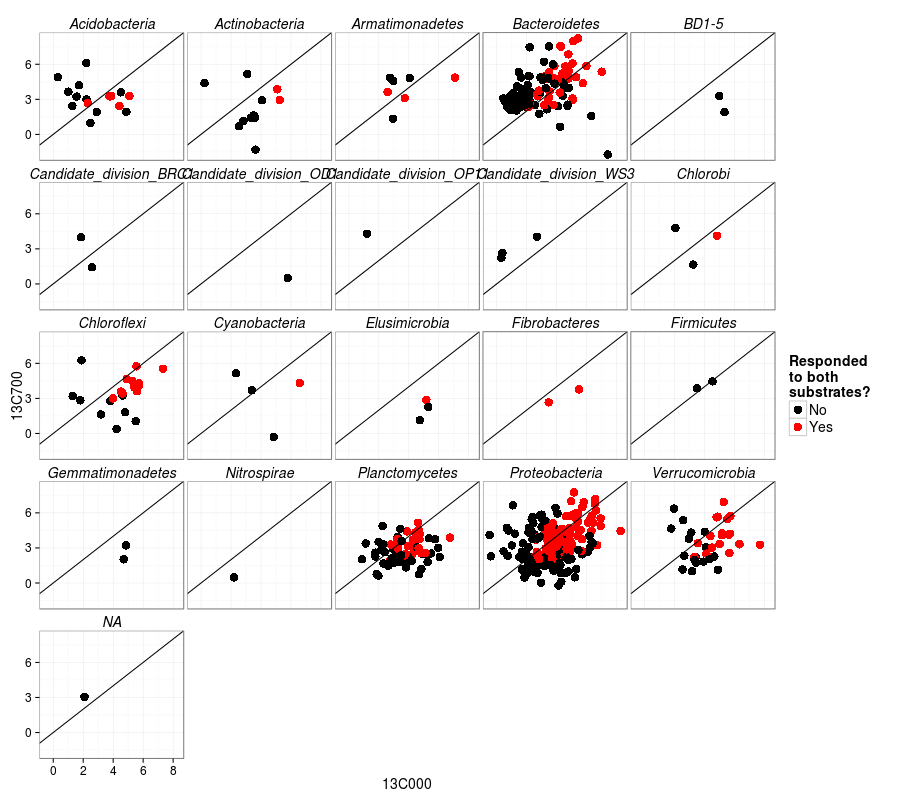

In [16]:
%%R -w 900 -h 800

p2 = ggplot(d5, aes(x = `13C000`, y = `13C700`, color = rspnse.t))

p2 = p2 + scale_color_manual(values = c("black", "red"))

p2 = p2 + facet_wrap(~Rank2)

p2 = p2 + geom_point(size = 4)

p2 = p2 + geom_abline(intercept = 0)

p2 = p2 + theme_bw()

p2 = p2 + labs(color = "Responded\nto both\nsubstrates?")

p2 = p2 + theme(strip.background = element_blank(),
              strip.text = element_text(size = 14, face = "italic"),
              axis.text = element_text(size = 12),
              axis.title = element_text(size = 14),
              legend.title = element_text(size = 14),
              legend.text = element_text(size = 14))

p2

In [17]:
%%R
FDR = 0.10

df.rspndrs = read.csv("/var/seq_data/priming_exp/data/l2fc_table.csv") %>%
    filter(Treatment %in% c("13C000", "13C700")) %>%
    group_by(OTU, Treatment) %>%
    summarize(minP = min(padj)) %>%
    filter(minP <= FDR) %>%
    group_by() %>%
    spread(Treatment, minP)

rspnse = function(x) {
    ifelse(sum(x <= FDR, na.rm = TRUE) == 2, "Both", ifelse(!is.na(x[1]), "Cellulose Only", "Root Exudate Pulse"))
}

df.rspndrs$rspnse = apply(df.rspndrs[,c("13C000", "13C700")], 1, rspnse)

df.rspndrs = df.rspndrs %>% select(OTU, rspnse)

df.rspndrs

Source: local data frame [523 x 2]

         OTU             rspnse
1      OTU.1     Cellulose Only
2     OTU.10               Both
3   OTU.1009               Both
4    OTU.101     Cellulose Only
5   OTU.1016 Root Exudate Pulse
6  OTU.10167               Both
7  OTU.10192 Root Exudate Pulse
8    OTU.102               Both
9  OTU.10213 Root Exudate Pulse
10 OTU.10228               Both
..       ...                ...


In [18]:
%%R
df.700 = l2fc.all %>%
        filter(Treatment %in% c("13C000", "13C700")) %>%
        left_join(df.rspndrs) %>%
        group_by(Rank2) %>%
        mutate(phylum.rspnse = ifelse(sum(!is.na(rspnse)) > 0, "rspndr", "none")) %>%
        filter(phylum.rspnse == "rspndr") %>%
        group_by(OTU, Rank2, Rank3, Treatment) %>%
        summarize(max.l2fc = max(log2FoldChange, na.rm = TRUE)) %>%
        group_by() %>%
        spread(Treatment, max.l2fc) %>%
        left_join(df.rspndrs)
print(df.700)

Joining by: "OTU"
Joining by: "OTU"
Source: local data frame [10,059 x 6]

         OTU          Rank2               Rank3      13C000     13C700
1      OTU.1 Actinobacteria       Micrococcales  2.53194715  0.7046301
2     OTU.10 Proteobacteria Alphaproteobacteria  5.26551206  5.9538625
3    OTU.100 Actinobacteria     Thermoleophilia -0.70128335 -1.9787095
4   OTU.1000 Actinobacteria Propionibacteriales  0.03255133  0.2372247
5  OTU.10000 Proteobacteria Deltaproteobacteria -0.64237617  1.2968985
6  OTU.10009 Proteobacteria  Betaproteobacteria          NA  1.3617273
7   OTU.1001 Proteobacteria Deltaproteobacteria  2.04268588 -0.2305969
8  OTU.10015 Planctomycetes    Planctomycetacia  0.90396514         NA
9  OTU.10016 Proteobacteria Alphaproteobacteria          NA         NA
10 OTU.10017  Acidobacteria               DA023          NA         NA
..       ...            ...                 ...         ...        ...
Variables not shown: rspnse (chr)


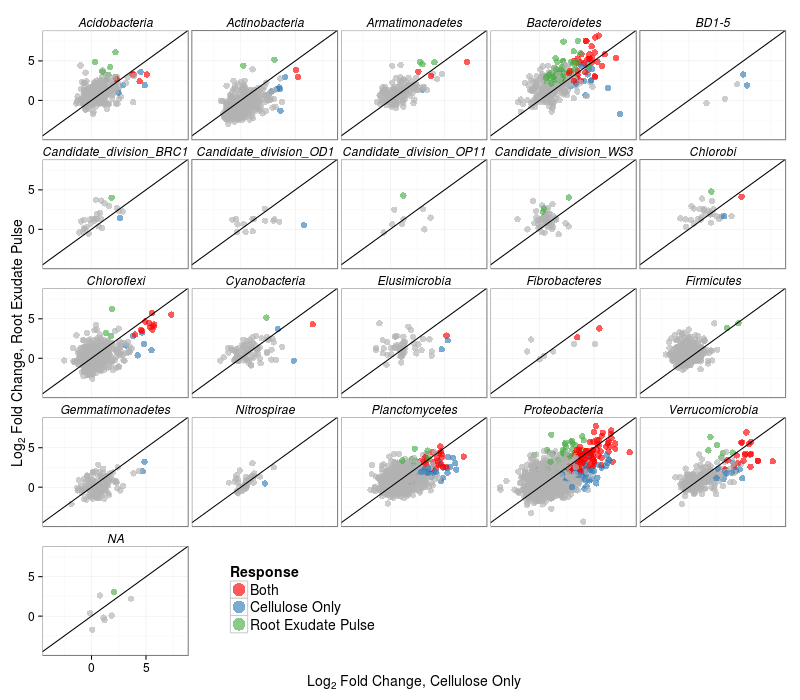

In [51]:
%%R -w 800 -h 700
FDR = 0.10

colours = c("red", "#377eb8", "#4daf4a")

p3 = ggplot(df.700, aes(x = `13C000`, y = `13C700`, color = rspnse))

#p = p + scale_color_manual(values = c("black", "red"))

p3 = p3 + facet_wrap(~Rank2)

p3 = p3 + geom_point(size = 3, alpha = 0.65)

p3 = p3 + geom_abline(intercept = 0)

p3 = p3 + scale_color_manual(values = colours, na.value = "grey70")

p3 = p3 + theme_bw()

p3 = p3 + labs(color = "Response")

p3 = p3 + labs(y = expression(paste("", Log[2]," Fold Change,"," Root Exudate Pulse",sep="")), 
             x = expression(paste("", Log[2]," Fold Change,"," Cellulose Only",sep="")))


p3 = p3 + theme(strip.background = element_blank(),
              strip.text = element_text(size = 12, face = "italic"),
              axis.text = element_text(size = 12),
              axis.title = element_text(size = 14),
              legend.title = element_text(size = 14),
              legend.text = element_text(size = 14),
              legend.position=c(0.35,0.09))
p3 = p3 + guides(color = guide_legend(override.aes = list(size = 6)))

p3

In [58]:
%%R 
pdf("figs/LinReg_phylum_13CCv13C700.pdf", width = 11, height = 10)
grid.arrange(p3, ncol=1)
dev.off()

png 
  2 


In [59]:
FileLink("figs/LinReg_phylum_13CCv13C700.pdf")

/home/ashley/priming_exp/figs/LinReg_phylum_13CCv13C700.pdf

In [60]:
%%R 
png("figs/LinReg_phylum_13CCv13C700.png", width = 11, height = 10, units = "in", res = 600)
grid.arrange(p3, ncol = 1)
dev.off()

png 
  2 


In [62]:
FileLink("figs/LinReg_phylum_13CCv13C700.png")

/home/ashley/priming_exp/figs/LinReg_phylum_13CCv13C700.png